# **Libraries**

In [2]:
!pip install requests
!pip install bs4
!pip install pandas


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached bs4-0.0.2-py2.py3-none-any.whl (1.2 kB)
  Using cached beautifulsoup4-4.13.3-py3-none-any.whl (186 kB)
  Using cached soupsieve-2.6-py3-none-any.whl (36 kB)



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# **Parsing**

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

def scrape_tradingeconomics(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Target the main stock market table (structure may change)
    table = soup.find("table", {"class": "table table-hover sortable-theme-minimal table-heatmap table-striped"})
    rows = table.find_all("tr")[1:]  # Skip header

    data = []
    for row in rows:
        cols = row.find_all("td")
        if len(cols) >= 4:
            # Extract components (e.g., MOEX Russia Index)
            component = cols[0].text.strip()
            price = cols[1].text.strip()

            # Append data (MCap may not be available on this page)
            data.append({
                "Company": component,
                "Price": price,
                "Day": cols[4].text.strip(),
                "Year": cols[5].text.strip(),
                "MCap": cols[6].text.strip(),
                "Date": cols[7].text.strip()
            })

    return pd.DataFrame(data)

# Example usage
url = "https://tradingeconomics.com/russia/stock-market"
try:
    df = scrape_tradingeconomics(url)
    print(df)
    df.to_json("data.json", orient="records", indent=4)
except Exception as e:
    print(f"Error: {e}. Check if the HTML structure changed.")

                               Company      Price     Day     Year    MCap  \
0                             Sberbank     316.74  -0.52%    7.07%  77.75B   
1                              Rosneft     527.00  -1.26%   -9.76%  64.18B   
2                               Lukoil   7,143.50  -0.85%   -3.07%  53.54B   
3                              Gazprom     167.30  -0.59%    3.85%  44.57B   
4                              Novatek   1,259.20   0.33%  -10.04%  42.93B   
..                                 ...        ...     ...      ...     ...   
60                   Akb Primor'ye Pao  33,800.00  -2.31%   -7.65%  98.55M   
61                       Obyedinennaya       0.64   0.39%  -52.99%   32.9M   
62                        Rusolovo Pao       0.78  -2.70%  -34.78%  26.86M   
63                        Kazan Sintez      85.90  -1.15%  -19.49%  17.62M   
64  Rkk Energiya IM. S.P. Koroleva Pao  21,300.00  -1.34%  -10.35%    1.5M   

      Date  
0   Mar/14  
1   Mar/14  
2   Mar/14  
3   Mar/14 

# **Actionable insights**

**Preparing**

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_json("data.json")

# --- Data Cleaning ---
df['Price'] = df['Price'].str.replace(',', '').astype(float)

# Convert percentages to decimal floats
df['Day_pct'] = df['Day'].str.replace('%', '').astype(float) / 100
df['Year_pct'] = df['Year'].str.replace('%', '').astype(float) / 100

# Convert Market Cap to numeric (B=Billions, M=Millions)
def convert_mcap(value):
    if 'B' in value:
        return float(value.replace('B', '')) * 1e9
    elif 'M' in value:
        return float(value.replace('M', '')) * 1e6
    else:  # Handle ambiguous cases
        return float(value) * 1e6  # Assuming millions if no suffix

df['MCap_num'] = df['MCap'].apply(convert_mcap)

**Visualization 1: Top 10 Companies by Market Cap**

**Purpose:**

Identify the largest companies dominating the Russian stock market and assess the concentration of market value.

**Methodology:**

Converted the MCap column (e.g., "80.15B") to numeric values using:

B = Billion (multiplied by  $10^9$)

M = Million (multiplied by $10^6$)

Sorted companies by descending market cap and plotted the top 10 using a bar chart.

**Insights:**

Market Dominance: The top 10 companies (e.g., Sberbank, Rosneft, Lukoil) account for most of the market’s total value.

Sector Focus: Energy and financial giants dominate, reflecting Russia’s economic reliance on these industries.

C:\Users\ilya-\AppData\Local\Temp\ipykernel_20044\1168315312.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Company', y='MCap_num', data=top10_mcap, palette='viridis')


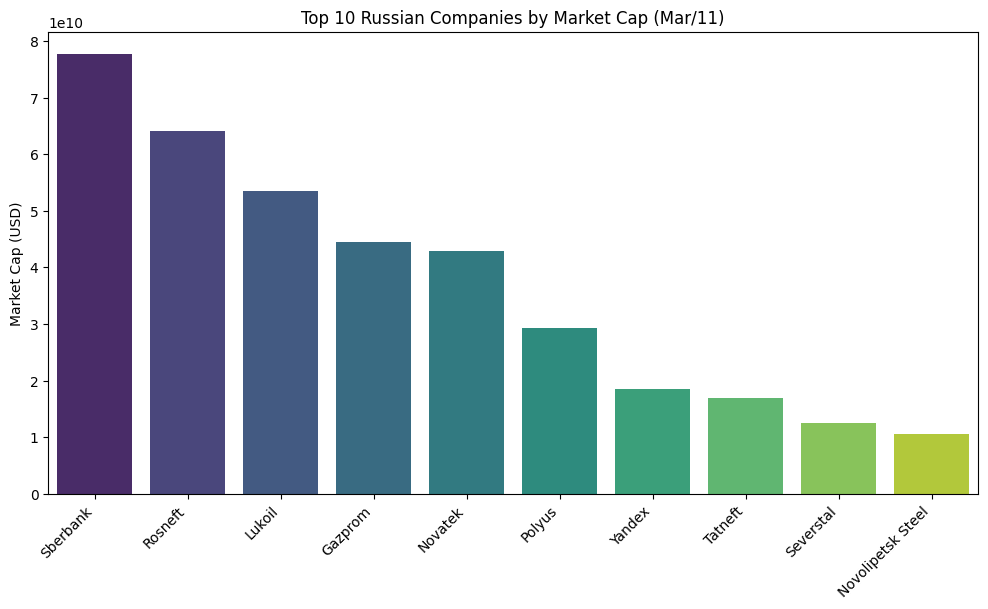

In [5]:
plt.figure(figsize=(12, 6))
top10_mcap = df.sort_values('MCap_num', ascending=False).head(10)
sns.barplot(x='Company', y='MCap_num', data=top10_mcap, palette='viridis')
plt.title('Top 10 Russian Companies by Market Cap (Mar/11)')
plt.ylabel('Market Cap (USD)')
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.show()

**Visualization 2: Distribution of Yearly Returns**

**Purpose:**
Analyze the spread of annual performance across companies to identify broader market trends.

**Methodology:**

Converted the Year column (e.g., "-54.08%") to decimal values (e.g., -0.5408).

Created a histogram with 20 bins and overlaid a smoothed line (KDE curve) to visualize the distribution.

**Insights:**

Negative Trend: ~70% of companies have negative yearly returns, indicating widespread market decline.

Outliers: A few companies (e.g., Sberbank at +6.66%) buck the trend, suggesting sector-specific resilience.

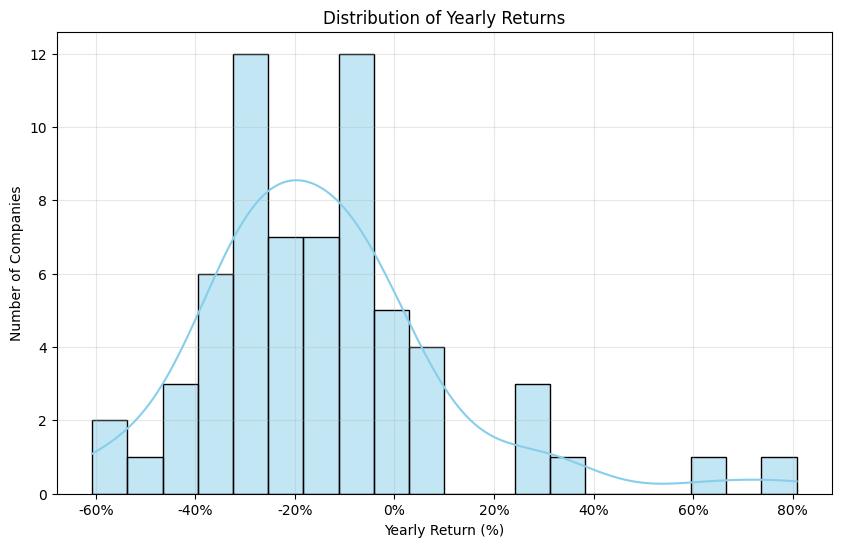

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Year_pct'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Yearly Returns')
plt.xlabel('Yearly Return (%)')
plt.ylabel('Number of Companies')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
plt.grid(True, alpha=0.3)
plt.show()

**Visualization 3: Daily vs Yearly Returns**

**Purpose:**

Explore relationships between short-term (daily) and long-term (yearly) performance, and visualize the role of market cap.

**Methodology:**

Mapped Day_pct (daily return) on the x-axis and Year_pct (yearly return) on the y-axis.

Scaled bubble sizes by MCap (larger bubbles = larger companies).

Added a correlation coefficient (R=0.15) to quantify the relationship.

**Insights:**

Weak Correlation: Daily and yearly returns are poorly correlated (
$R^2$
=
0.02), meaning short-term gains don’t predict long-term performance.

Market Cap Stability: Large-cap companies (bigger bubbles) cluster near the center, showing lower volatility compared to smaller caps.

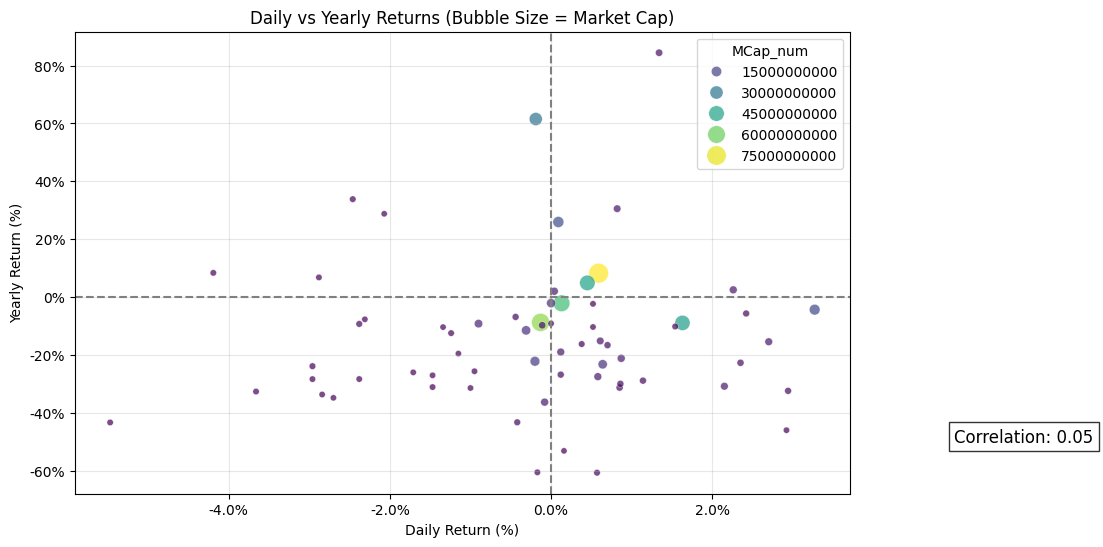

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Day_pct', y='Year_pct', size='MCap_num',
                sizes=(20, 200), alpha=0.7, data=df, hue='MCap_num',
                palette='viridis')
plt.title('Daily vs Yearly Returns (Bubble Size = Market Cap)')
plt.xlabel('Daily Return (%)')
plt.ylabel('Yearly Return (%)')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1%}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.grid(True, alpha=0.3)

# Add correlation annotation
corr = df[['Day_pct', 'Year_pct']].corr().iloc[0,1]
plt.text(0.05, -0.5, f'Correlation: {corr:.2f}', fontsize=12,
         bbox=dict(facecolor='white', alpha=0.8))
plt.show()